In [1]:
import numpy as np # NumPy
from scipy.optimize import fsolve 
from IPython.display import Image
import pandas as pd # Pandas
pd.options.display.float_format = '{:5,.4E}'.format

# Calculating the factor the determines if the Vavilov distribution can be approximated by a Landau

Bethe-Bloch mean energy loss:
$$
\left\langle-\frac{dE}{dx} \right\rangle \frac{1}{\rho} =  K z_0^2 \frac{1}{\beta^2} \frac{Z}{A M_u} \cdot\left[\frac{1}{2}\ln \left(\frac{2m_e c^2 \beta^2 W_{max}}{I^2 \cdot (1-\beta^2)}\right) - \beta^2\right]
$$

$$
K/M_u = 4 \pi N_A r_e^2 m_e c^2 /M_u = 0.307075\space \text{MeV g}^{-1} \text{cm}^2
$$

$$ r_e  = \frac{e^2}{4\pi\varepsilon_0 m_e c^2} $$
$$ M_u = 1 \frac{g}{mol} \quad z_0=1 $$
$$ \left( W_{max} \equiv \epsilon_{max} \right) $$

For __silicon__:
$$ Z = 14 $$
$$ A = 28.085 $$ 
$$ \rho = 2.329085 \text{  g cm}^{-3} $$
$$ I = 173 \text{ eV} % \quad \text{(mean excitation energy)} $$

<!-- 
$$
n = \frac{N_A Z \rho}{A M_u}
$$ -->

## Calculating $\beta$ for a proton of energy $E_k$

$$ E_k = (\gamma - 1) m_o c^2 $$
$$ \gamma = \frac{E_k + m_o c^2}{m_o c^2} $$
$$ \beta^2 = 1 - \left(\frac{m_o c^2}{E_k +m_o c^2} \right)^2 $$

for a proton of energy $E_k=120\space \text{GeV}$, $m_0 = 938.272\space \text{MeV/c}^2$

In [2]:
energy = 120e3 # MeV  (120 GeV)
# m_particle = 938.272088 # MeV/c^2  protons 
m_particle = 938.213 # MeV/c^2     protons (older value)

gamma = (energy + m_particle)/m_particle
beta_2 = 1 - m_particle**2/(m_particle + energy)**2

print(" gamma: ", gamma, "\n", "beta²: ", beta_2)

 gamma:  128.90272571367058 
 beta²:  0.999939816727599


from https://academic.oup.com/book/43645/chapter/365027598#404941541 :

 The parameter $\kappa$ of the Vavilov distribution determines if it becomes close to a Landau ($\kappa\rightarrow0$) or a Gaussian ($\kappa  10$).

To calculate $\kappa$: 
$$
\kappa = \frac{\xi}{\epsilon_{max}}
$$

where:
$$
\xi = \frac{1}{2} K \frac{Z}{A} \frac{s} {\beta^2}
$$

 
$s = \Delta x \cdot \rho$

and from  https://nap.nationalacademies.org/read/20066/chapter/10#188 : <!-- (older book) -->
$$
\epsilon_{max} = \frac{2m_e c^2 \beta^2}{1-\beta^2}\left[ 1 + \frac{2m_e}{M}\frac{1}{\sqrt{1-\beta^2}} + \left(\frac{m_e}{M}\right)^2 \right]^{-1}
$$ 

where $M$ is the mass of the incoming particle.

Also written as:

$$
\epsilon_{max} = \frac{2m_e c^2 \beta^2 \gamma^2} { 1 + \frac{2\gamma m_e}{M} + \left(\frac{m_e}{M}\right)^2}
$$ 

## Applying this to a thin silicon layer (50$\mu \text{m}$)
(The masses are either multiplied by $c^2$ or in a ratio, the mass units used are $\text{MeV}/c^2$)

In [3]:
### variables values
m_electron = 0.51099895 # MeV/c^2
z_0 = 1 # electric charge of incoming particle
delta_x = 5e-3 # cm  (50um)

### silicon
Z = 14   # atomic number
A = 28.085  # atomic weight
density = 2.329085 # g cm^-3
mean_excitation = 173e-6 # MeV  (mean excitation energy of Silicon: 173 eV)

s = delta_x * density # g cm^-2
K = 0.307075 # MeV g^-1 cm^2

In [4]:
def xi_func(energy):
    beta_2 = 1 - m_particle**2/(m_particle + energy)**2
    return (1/2 * K) * (Z / A) * (s / beta_2)

def eps_max_func(energy):
    gamma = (energy + m_particle)/m_particle
    beta_2 = 1 - m_particle**2/(m_particle + energy)**2
    return (2 * m_electron * beta_2 * gamma**2) / (1 + 2*gamma*m_electron/m_particle + (m_electron/m_particle)**2) # MeV

def kappa_func(energy, kappa_value=0.01):
    """kappa as a function of the energy (to find the zeros for k=kappa_value)"""
    gamma = (energy + m_particle)/m_particle
    beta_2 = 1 - m_particle**2/(m_particle + energy)**2
    return xi_func(energy) / eps_max_func(energy) - kappa_value

In [5]:

xi = (1/2 * K) * (Z / A) * (s / beta_2) # MeV

epsilon_max = eps_max_func(energy) # MeV

kappa = xi / epsilon_max

print("k =",kappa)

k = 5.98637846070628e-08


## Comparison with calculations from https://nap.nationalacademies.org/read/20066/chapter/10#189

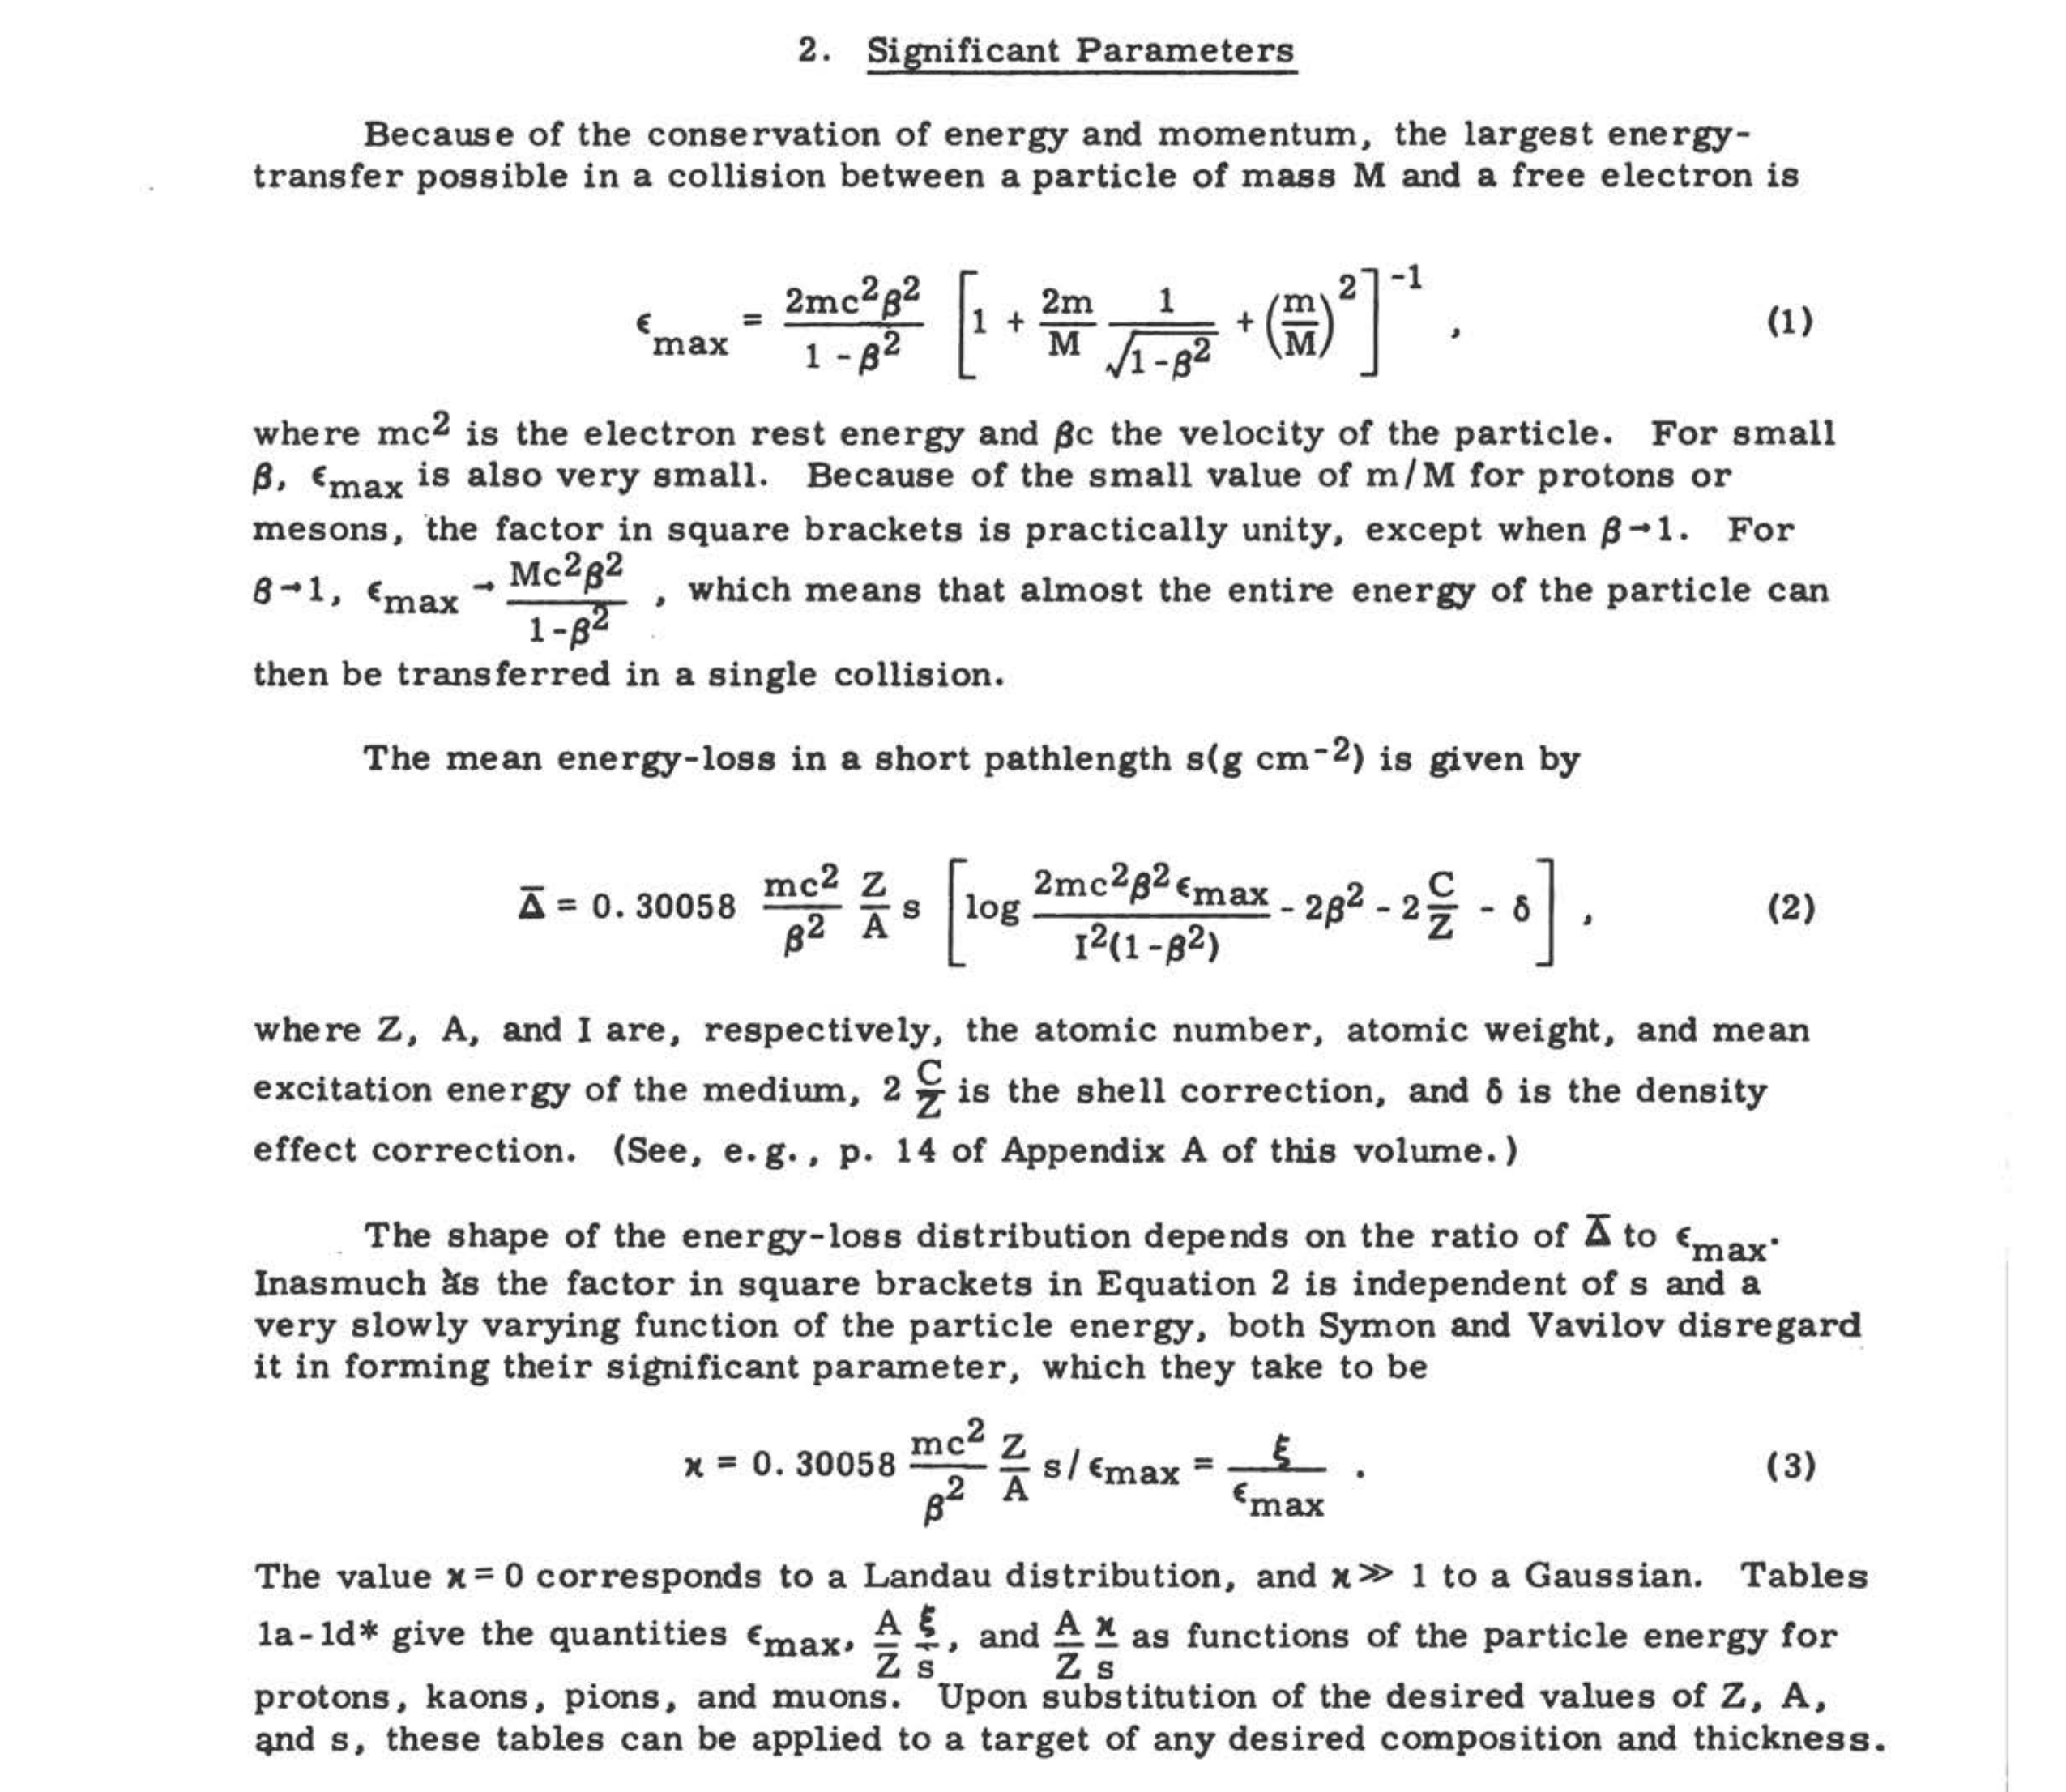

In [6]:
Image("epsilon and xi formulas.png", width=1000)

Then follows a table with the values calculated for different energies:

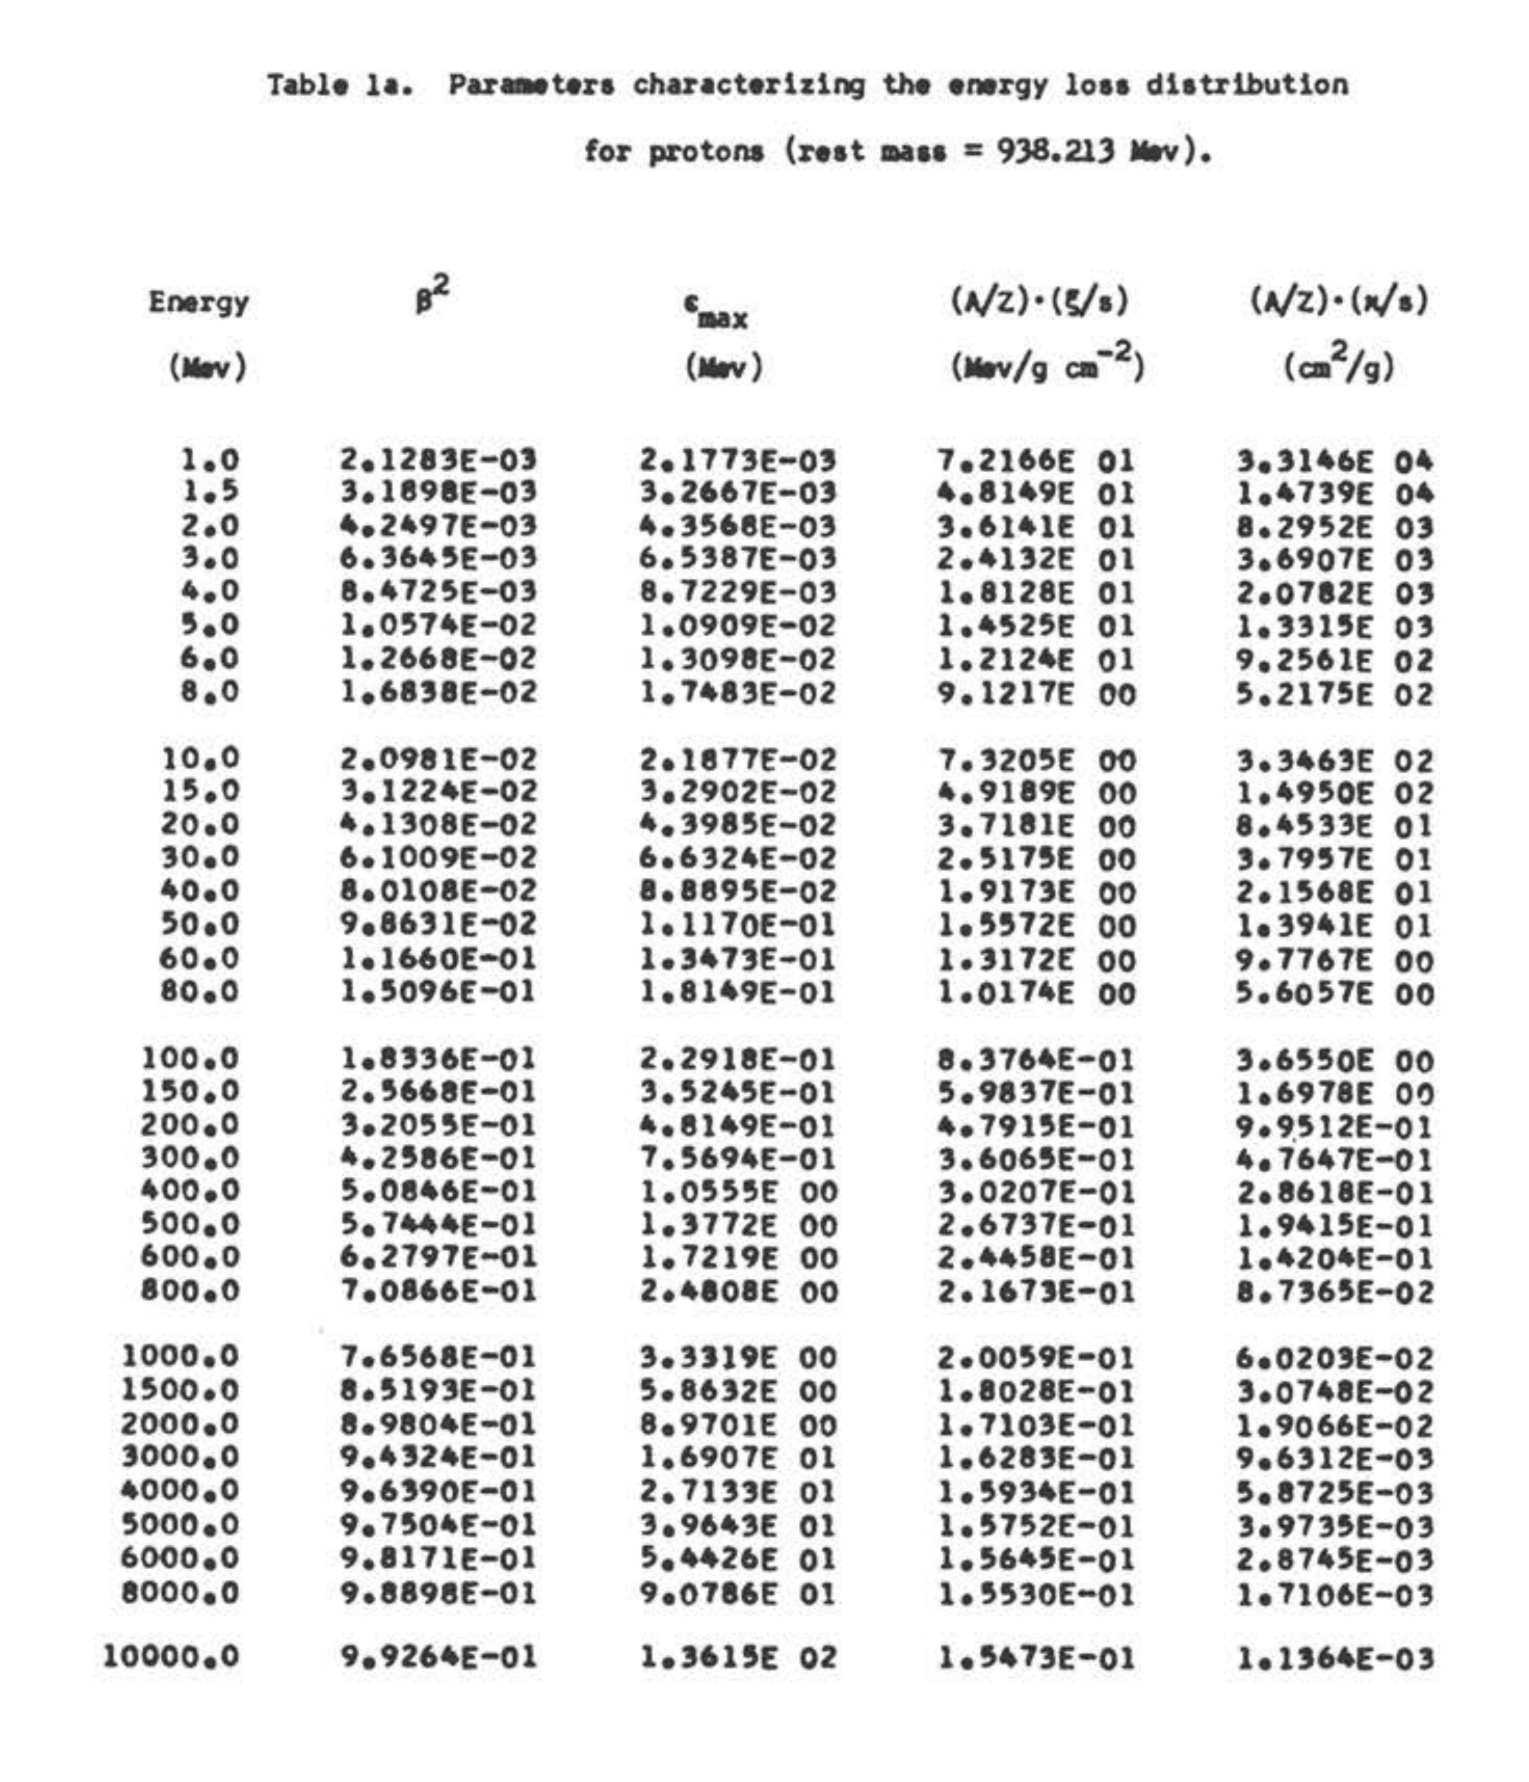

In [7]:
Image("Table of k and xi values.png", width=800)

Comparison of these values with my previous calculations

In [8]:
# Values from 100 MeV to 10 GeV
energy_array = np.array([100,150,200,300,400,500,600,800,1000,1500,2000,3000,4000,5000,6000,8000,10000])


In [9]:
table_data = np.vstack((1 - m_particle**2 / (m_particle+energy_array)**2,
              eps_max_func(energy_array),
              A/Z * xi_func(energy_array) / s,
              A/Z * kappa_func(energy_array,kappa_value=0) / s))

df = pd.DataFrame(data=table_data.transpose(), columns=("beta^2","epsilon_max","A/Z*xi/s","A/Z*kappa/s"))
df.insert(0, "Energy", pd.DataFrame(energy_array,dtype=np.int_))

display(df)

Energy     beta^2  epsilon_max   A/Z*xi/s  A/Z*kappa/s
0      100 1.8336E-01   2.2919E-01 8.3735E-01   3.6534E+00
1      150 2.5668E-01   3.5247E-01 5.9816E-01   1.6971E+00
2      200 3.2055E-01   4.8153E-01 4.7898E-01   9.9471E-01
3      300 4.2587E-01   7.5699E-01 3.6053E-01   4.7627E-01
4      400 5.0847E-01   1.0556E+00 3.0196E-01   2.8607E-01
5      500 5.7444E-01   1.3773E+00 2.6728E-01   1.9407E-01
6      600 6.2798E-01   1.7221E+00 2.4450E-01   1.4198E-01
7      800 7.0866E-01   2.4809E+00 2.1666E-01   8.7329E-02
8     1000 7.6569E-01   3.3321E+00 2.0052E-01   6.0178E-02
9     1500 8.5193E-01   5.8636E+00 1.8022E-01   3.0736E-02
10    2000 8.9804E-01   8.9708E+00 1.7097E-01   1.9059E-02
11    3000 9.4324E-01   1.6908E+01 1.6278E-01   9.6272E-03
12    4000 9.6390E-01   2.7135E+01 1.5929E-01   5.8701E-03
13    5000 9.7504E-01   3.9646E+01 1.5747E-01   3.9719E-03
14    6000 9.8171E-01   5.4431E+01 1.5640E-01   2.8733E-03
15    8000 9.8898E-01   9.0793E+01 1.5525E-01   1.7099E-03
16   10000 9.9264E-01   1.3616E+02 1.5468E-01   1.1360E-03

## At what energy ($\gamma$) the value $\kappa = 0.01$

In [10]:
kappa_value = 0.01

target_energy = fsolve(kappa_func, x0=500, args=(kappa_value))
print(target_energy[0], "MeV")

148.80746742515953 MeV
